**TO DO**

- Think about visualizing and comparing the Two bands (e.g. followers, popularity, related artists)
- Add track score in barplot

**THIS NOTEBOOK:**

- Retrieve metadata at Spotify about songs - Evanescence
- Retrieve metadata at Spotify about songs - Within temptation
- Merge data retrieve from Spotify with lyrics obtained in previous notebook via web scrapping
- Some Visualization

**NEXT NOTEBOOKS:**

- NLP (sentiment analysis)
- Visualization
- Retrieve data about both bands from Twitter
- Apply Sentiment Analysis to Twitter data


REFS:

- https://developer.spotify.com/dashboard/login
- https://developer.spotify.com/documentation/web-api/reference/
- https://spotipy.readthedocs.io/en/latest/#

In this notebook I'll be using Spotify API to obtain more data about the lyrics we scrapped from the web in the last notebook. To have access to Spotify API is necessary to request you credentials at https://developer.spotify.com/dashboard/login.

I'll be using Spotipy which is a lightweight Python library for the [Spotify Web API](https://developer.spotify.com/documentation/web-api/).

# Access to Spotify API 

In [1]:
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials 

try:
    import private # .py file with my credentials 
    # maybe redirect uri will be required for some of the commands 
    redirect_uri = private.redirect_uri

    # credentials
    username = private.username
    client_id=private.cid 
    client_secret=private.secret

except ModuleNotFoundError:
    import settings # have the credentials of another user
    redirect_uri = settings.redirect_uri

    # credentials
    username = settings.username
    client_id=settings.cid
    client_secret=settings.secret   
    
client_credentials_manager = SpotifyClientCredentials(client_id, client_secret) 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)


# Retrieving information about an artist

Spotipy supports a number of different ID types:

    `Spotify URI` - The resource identifier that you can enter, for example, in the Spotify Desktop client’s search box to locate an artist, album, or track. Example: spotify:track:6rqhFgbbKwnb9MLmUQDhG6

    `Spotify URL` - An HTML link that opens a track, album, app, playlist or other Spotify resource in a Spotify client. Example: http://open.spotify.com/track/6rqhFgbbKwnb9MLmUQDhG6

    `Spotify ID` - A base-62 number that you can find at the end of the Spotify URI (see above) for an artist, track, album, etc. Example: 6rqhFgbbKwnb9MLmUQDhG6

In general, any Spotipy method that needs an _artist, album, track or playlist ID_ will accept ids in any of the above form.

**source: https://spotipy.readthedocs.io/en/latest/#ids-uris-and-urls**

In order to retrieve information about an artist we need to retrieve one of these IDs, for this we use the method `search`. In the function below we will use this and other methods from Spotipy to retrieve information about an artist.

The information retrieved by the following function is:



In [2]:
def retrieve_artist_info(artist):
    
    """ Retrieve main information about an artist given artist's name which includes also name of bands.
    
    Input:
        artist : artist's name (string)
    
    Output:
        dictionary with main info about artist, including related artist. """
    
    # find artist by name and extract uri
    
    artist_uri = sp.search(q='artist:' + artist, type='artist')['artists']['items'][0]['uri']
    
    # Extract info about artist
    
    artist_info = sp.artist(artist_uri)
    
    # Obtain list of related artists. Similarity is based on analysis of the Spotify community’s listening history.

    related = sp.artist_related_artists(artist_uri)
    
    related_artists = []

    for idx in range(len(related['artists'])):
        related_artists.append(related['artists'][idx]['name'])
    
    return {'id': artist_info['id'],
            'name' : artist_info['name'],
            'genres': ', '.join(artist_info['genres']),
            'artist_popularity' : artist_info['popularity'],
            'num_followers' : artist_info['followers']['total'],
            'related_artists': ', '.join(related_artists),
            'external_urls': artist_info['external_urls']['spotify'],
            'uri': artist_uri}
    

In [9]:
import pandas as pd

def build_dataframe_artists_info(list_artists):
    """ Build a dataframe with info from a list of artists (names of artists)"""
    
    all_info = []

    for name in list_artists:
        all_info.append(retrieve_artist_info(name))
        
    return pd.DataFrame(all_info)
    

In [10]:
df = build_dataframe_artists_info(['evanescence','within temptation'])
df.columns

Index(['id', 'name', 'genres', 'artist_popularity', 'num_followers',
       'related_artists', 'external_urls', 'uri'],
      dtype='object')

In [11]:
# selecting only the columns I'm interested in

df = df[['name', 'genres', 'artist_popularity', 'num_followers',
       'related_artists']]

df

,name,genres,artist_popularity,num_followers,related_artists
0,Evanescence,"alternative metal, post-grunge",76,2540990,"Amy Lee, We Are The Fallen, Within Temptation,..."
1,Within Temptation,"dutch metal, gothic metal, gothic symphonic me...",68,741985,"Leaves' Eyes, Delain, Epica, Tarja, Visions of..."


## Comparing Popularity and Number of Followers

Text(0.5, 1.0, 'Comparison of popularity - Evanescence x Within Temptation.\n')

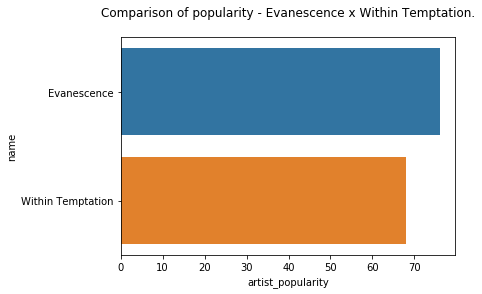

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.barplot(data=df, y='name',x='artist_popularity')
plt.title("Comparison of popularity - Evanescence x Within Temptation.\n")

Text(0.5, 1.0, 'Comparison of Number of Followers - Evanescence x Within Temptation.\n')

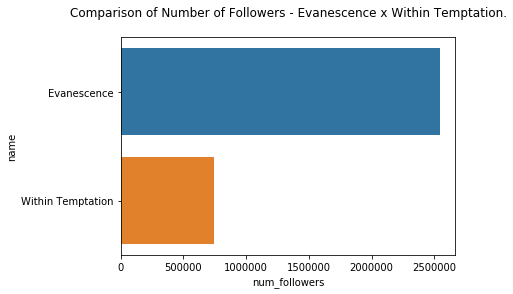

In [13]:
sns.barplot(data=df, y='name',x='num_followers')
plt.title("Comparison of Number of Followers - Evanescence x Within Temptation.\n")

## Genres and Related Artists

We will see more about Word Clouds in a next notebook where we will perform some NLP analysis (topic analysis and sentiment analysis). However, I'll make use of some word clouds to visualize the genres associated with each band as well as the artists related with them individually and also in common. 

In [14]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [15]:
# Generate word clouds with genres related to each band 

evanescence_genres_word_cloud = WordCloud(background_color="black",random_state=123,colormap='Reds').generate(df['genres'][df['name']=='Evanescence'][0])
within_genres_word_cloud = WordCloud(background_color="black",random_state=123,colormap='Blues').generate(df['genres'][df['name']=='Within Temptation'][1])


(-0.5, 399.5, 199.5, -0.5)

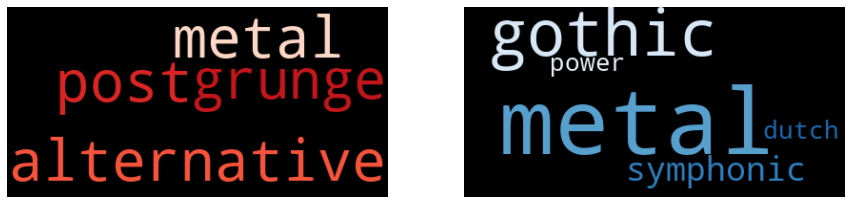

In [16]:
fig = plt.figure(figsize = (15,15))
plt.subplot(221)
plt.imshow(evanescence_genres_word_cloud, interpolation="bilinear")
plt.axis('off')
plt.subplot(222)
plt.imshow(within_genres_word_cloud, interpolation="bilinear")
plt.axis('off')

## Which related artists Evanescence and Within Temptation have in common considering the listeners of Spotify?

In [17]:
common_artists = set(df['related_artists'][df['name']=='Evanescence'][0].split(',')).intersection(set(df['related_artists'][df['name']=='Within Temptation'][1].split(',')))
common_artists=','.join(common_artists)
common_artists

' We Are The Fallen, Delain, Sirenia, Epica, Tarja, Lacuna Coil, Nightwish'

In [21]:
evanescence_artists_wc = WordCloud(background_color="black",random_state=123,colormap='Reds').generate(df['related_artists'][df['name']=='Evanescence'][0])
within_artists_wc = WordCloud(background_color="black",random_state=123,colormap='Blues').generate(df['related_artists'][df['name']=='Within Temptation'][1])
common_artists_wc = WordCloud(background_color="black",random_state=123,colormap='Purples').generate(common_artists)

(-0.5, 399.5, 199.5, -0.5)

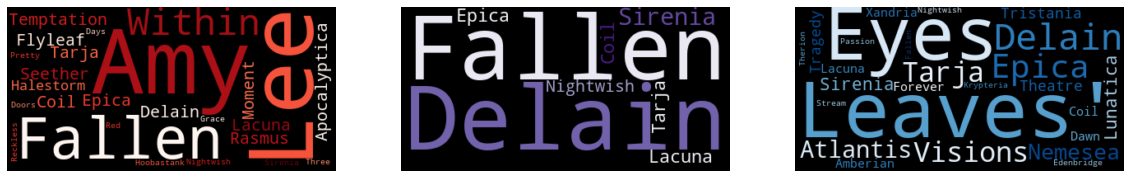

In [22]:
fig = plt.figure(figsize = (20,20))
plt.subplot(231)
plt.imshow(evanescence_artists_wc, interpolation="bilinear")
plt.axis('off')
plt.subplot(232)
plt.imshow(common_artists_wc, interpolation="bilinear")
plt.axis('off')
plt.subplot(233)
plt.imshow(within_artists_wc, interpolation="bilinear")
plt.axis('off')

So we can say that people that like `Evanescence` and `Within Temptation` also appreciate Apocalyptica, Delain, Epica, Lacuna Coil, Nightwish, Sirenia, and Tarja. In a recommender system point of view we could recommend people to explore this bands ;-)

# Artist top tracks

In [ ]:
import pandas as pd

def top_tracks_by_country(artist_uri, country = 'US'):
    """ Get Spotify catalog information about an artist’s top 10 tracks by country. """
    
    track_name = []
    track_id = []
    track_popularity = []

    top = sp.artist_top_tracks(artist_uri, country = country)
    
    for idx in range(len(top['tracks'])):
        track_name.append(top['tracks'][idx]['name'])
        track_id.append(top['tracks'][idx]['id'])
        track_popularity.append(top['tracks'][idx]['popularity'])
        
    dict_top = {'track_id': track_id,
               'track_name': track_name,
               'track_popularity': track_popularity}
        
    df = pd.DataFrame(dict_top)
    
    return df

In [ ]:
evanescence_uri = info_evanescence['uri']
df_evanescence_US = top_tracks_by_country(evanescence_uri)
df_evanescence_US

In [ ]:
df_evanescence_NL = top_tracks_by_country(evanescence_uri, country='NL')
df_evanescence_NL

In [ ]:
df_evanescence_US.equals(df_evanescence_NL)

Both countries have the same top 10 for Evanescence. And what about withing Temptation?

In [ ]:
within_temptation_uri = info_within_temptation['uri']

In [ ]:
df_within_temptation_US = top_tracks_by_country(within_temptation_uri)
df_within_temptation_NL = top_tracks_by_country(within_temptation_uri, country = 'NL')
df_within_temptation_US.equals(df_within_temptation_NL)

It seems that the taste of americans and dutchs differ when we talk about Within Temptation. Let's see which one are the top 10 in both countries.

In [ ]:
df_within_temptation_US

In [ ]:
df_within_temptation_NL

At the end both country like the same songs. However, Faster and Paradise score better in popularity in The Netherlands.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(7, 4))

# Plot top 10 in NL
sns.set_color_codes("pastel")
sns.barplot(x="track_popularity", y="track_name", data=df_within_temptation_NL,
            label="NL", color="b", alpha = 0.5)

# Plot top 10 in US
sns.set_color_codes("muted")
sns.barplot(x="track_popularity", y="track_name", data=df_within_temptation_US,
            label="US", color="r", alpha = 0.5)

# Add a legend and informative axis label
f.suptitle("Within Temptation's top 10 in US and The Netherlands")
ax.legend(ncol=1, loc="upper left", frameon=True)
ax.set(xlim=(5, 60), ylabel="",
       xlabel="Popularity of tracks")
sns.despine(left=True, bottom=True)




**Popularity:** Track's popularity has a value between 0 and 100, with 100 being the most popular. It is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.

source: https://developer.spotify.com/documentation/web-api/reference/artists/get-artists-top-tracks/

Curious to hear snippets of the top 10? Let's include `preview url` to above dataframes so you can have a taste ;-)

In [ ]:
import sys
import pandas as pd
# import streamlit as st
pd.set_option('display.max_colwidth', 0)
from IPython.display import Image, HTML

def insert_preview_url(df, track_id_list):
    """ Insert column with clickable link to snippet (30 seconds sample of a song) of songs."""
    
    list_preview_url = []

    for track_id in track_id_list:
        list_preview_url.append(sp.track(track_id)['preview_url'])
        
    df['preview_url'] = list_preview_url
    
    def make_clickable(val):
        if val is None:
            return 'No preview available'
        else:
            return '<a target="_blank" href="{}">{}</a>'.format(val, val)

    df = df.style.format({'preview_url': make_clickable})
    
    return df

In [ ]:
# Updated dataframe with top 10 of Evanescence in The Netherlands

df = df_evanescence_NL
track_id_list = df_evanescence_NL['track_id']

df_evanescence_NL_preview = insert_preview_url(df, track_id_list)
df_evanescence_NL_preview

In [ ]:
# Updated dataframe with top 10 of Within Temptation in The Netherlands

df = df_within_temptation_NL
track_id_list = df_within_temptation_NL['track_id']

df_within_temptation_NL_preview = insert_preview_url(df, track_id_list)
df_within_temptation_NL_preview

Unfortunately, Spotify don't provide snippets for all songs. Bad surprise that no songs in the top 10 have no snippets. A shame...

# Retrieving album's information

Now that we can retrieve among other information the artist's uri we are able to retrieve information about artist's albums. The following function was construct so relevant information about albums are retrieved and stored in a .csv file.

In [ ]:
import pandas as pd

def retrieving_albums_info(artist_uri, file_name, limit = 50, max_nr_albums=2000):
    """ 
    Retrieve albums information of a given artist_uri.
    
    Input:
        artist_uri : The Spotify URI for the artist.
        file_name: name of the .csv that will have the information retrieved
        
    Output:
        csv file with album information of a chosen artist
    
    
    """
    
    album_name = []
    album_id = []
    album_type = []
    artists = []
    release_date = []
    # release_date_precision = []
    cover_album = []
    total_tracks = []
    available_markets = []
    total_available_markets = []
    uri = []

    for i in range(0,max_nr_albums,50):
        albums_per_artist = sp.artist_albums(artist_uri, limit=limit, offset=i)
        for album in range(len(albums_per_artist['items'])):
            album_name.append(albums_per_artist['items'][album]['name'])
            album_id.append(albums_per_artist['items'][album]['id'])
            album_type.append(albums_per_artist['items'][album]['album_type'])
            artists.append(albums_per_artist['items'][album]['artists'][0]['name'])
            release_date.append(albums_per_artist['items'][album]['release_date'])
    #         release_date_precision.append(albums_per_artist['items'][album]['release_date_precision'])
            cover_album.append(albums_per_artist['items'][album]['images'][0]['url'])
            total_tracks.append(albums_per_artist['items'][album]['total_tracks'])
            available_markets.append(','.join(albums_per_artist['items'][album]['available_markets']))
            total_available_markets.append(len(albums_per_artist['items'][album]['available_markets']))
        
            uri.append(albums_per_artist['items'][album]['uri'])

    dict_albums = {'album_name':album_name,
                   'album_id': album_id,
                   'album_type' : album_type,
                   'artists': artists,
                   'release_date' : release_date,
    #                'release_date_precision' : release_date_precision,
                   'cover_album':cover_album,
                   'total_tracks':total_tracks,
                   'available_markets': available_markets,
                   'total_available_markets':total_available_markets,
                  'uri': uri}

    # creating dataframe

    df = pd.DataFrame(dict_albums)

    # dropping duplicates based on album_name and release_date

    df.drop_duplicates(subset=['album_name','release_date'], keep = 'first', inplace = True)
    
    # reset index
    
    df.reset_index(inplace = True)
    
    # Create year column
    
    df['release_date'] = pd.to_datetime(df['release_date'],  format='%Y-%m-%d')
    
    df['release_year'] = df['release_date'].apply(lambda x: x.year)
    
    # Ordering
    
    df = df[['album_id', 'album_name', 'album_type', 'artists', 'release_year','release_date', 'cover_album',
            'total_tracks','available_markets','total_available_markets', 'uri']]

    # saving result in csv

    df.to_csv("./data/"+file_name)
    
    return df


In [ ]:
artist_uri = info_evanescence['uri']
artist_uri

In [ ]:
df_albums_evanescence

In [ ]:
df_albums_evanescence.sort_values(by='release_year', ascending=False)

Before applying some filtering, I'll check if there were some single or album release these last 2 years by Evanescence.

In [ ]:
df_albums_evanescence[(df_albums_evanescence['release_year']>=2019) & (df_albums_evanescence['artists']=='Evanescence')]

In [ ]:
df_albums_evanescence[(df_albums_evanescence['release_year']>=2019) & (df_albums_evanescence['artists']=='Evanescence')].iloc[0]

In [ ]:
single_ID = df_albums_evanescence[(df_albums_evanescence['release_year']>=2019) & (df_albums_evanescence['artists']=='Evanescence')].iloc[0]['album_id']

Let's filter albums that are not of type compilation or single. First, compilations usually include tracks of other artists. Second, singles are usually included later in an album. Observe, that  in the dataframe above there are albums that should be classified as `compilation` (artists: Various Artists) but are still classified as `album`. Therefore, we will filter out `album_type` compilation and single, and `artists` Various Artists.

After all the filtering, a list of id of these albums will be created so we will use it to retrieve information about albums' tracks.

I'll include to this list the id of the newest single since we do not know when a new album will be released.

In [ ]:
df_albums_evanescence_filtered = df_albums_evanescence.copy()

# only albums of type 'album' and from artist 'eva'
df_albums_evanescence_filtered = df_albums_evanescence_filtered[(df_albums_evanescence_filtered['album_type']=='album')
                                                                &(df_albums_evanescence_filtered['artists']=='Evanescence')]

# organize by album's release date
df_albums_evanescence_filtered = df_albums_evanescence_filtered.sort_values(by='release_year')

# reset index
df_albums_evanescence_filtered.reset_index(inplace=True, drop = True)

In [ ]:
df_albums_evanescence_filtered.shape

Initially, we retrieved 77 albums. After, filtering we kept 9 albums which are not single or compilation. Notice that two of them have repeated entries. Album `Evanescence` have two versions where the Deluxe version has more tracks. On the other side, album `Synthesis` has also two versions (studio and Live). However, they have the same number of tracks. There is also another entry for `Synthesis` for the studio version with a different release date. Apparently, in Japan this album was released 2 days after the other countries. Because album `Synthesis` seems to differ only on the release date we will apply another filtering to eliminate this case. 

In [ ]:
df_albums_evanescence_filtered.drop_duplicates(subset=['album_name','release_year','total_tracks'], keep='first', inplace = True)

In [ ]:
df_albums_evanescence_filtered.reset_index(inplace=True, drop=True)
df_albums_evanescence_filtered

In [ ]:
df_albums_evanescence_filtered.shape

At this point we have 8 albums and we are still keeping the two versions of `Evanescence` and `Synthesis`. Any repeated tracks will be eliminated later. Now we use the `album_id` of these 8 albums and the last single, `The Chain` to retrieve their tracks.

In [ ]:
# creating a list with albums ids based on the last dataframe

album_id_list = df_albums_evanescence_filtered['album_id'].tolist()
album_id_list.append(single_ID)
album_id_list

**TO DO**

- Try to make smaller functions and put all together to have metadata and audio features from tracks of all albums.

In [ ]:
def retrieve_tracks_info(album_id):
    """ Retrieve info of tracks in an album"""
    
    album_name = []
    track_id = []
    track_name = []
    track_duration = []
    track_popularity = []
    track_preview = [] 
    danceability = []
    energy = []
    key = []
    loudness = []
    mode = []
    speechiness = []
    acousticness = []
    instrumentalness = []
    liveness = []
    valence = []
    tempo = []
    
    for idx in range(len(tracks_info['items'])):
        t_id = tracks_info['items'][idx]['id']
        track_metadata=sp.track(t_id)
        album_name.append(track_metadata['album']['name'])
        track_id.append(track_metadata['id'])
        track_name.append(track_metadata['name'])
        track_duration.append(track_metadata['duration_ms'])
        track_popularity.append(track_metadata['popularity'])
        track_preview.append(track_metadata['preview_url'])
        
        
    # obtain audio features of a track
    
    for idx in range(len(track_id)):
        audio_features = sp.audio_features(df_metadata['track_id'])[idx]
        danceability.append(audio_features['danceability'])
        energy.append(audio_features['energy'])
        key.append(audio_features['key'])
        loudness.append(audio_features['loudness'])
        mode.append(audio_features['mode'])
        speechiness.append(audio_features['speechiness'])
        acousticness.append(audio_features['acousticness'])
        instrumentalness.append(audio_features['instrumentalness'])
        liveness.append(audio_features['liveness'])
        valence.append(audio_features['valence'])
        tempo.append(audio_features['tempo'])
        
        
        
    dict_tracks = {'album_name':album_name,
                  'track_id':track_id,
                  'track_name':track_name,
                  'track_duration':track_duration,
                  'track_popularity':track_popularity,
                  'track_preview':track_preview,
                  'danceability': danceability,
                   'energy': energy,
                   'key': key,
                   'loudness': loudness,
                   'mode': mode,
                   'speechiness': speechiness,
                   'acousticness': acousticness,
                   'instrumentalness': instrumentalness,
                   'liveness': liveness,
                   'valence': valence,
                   'tempo': tempo}
    
    df_tracks_info = pd.DataFrame(dict_tracks)
    
    return df_tracks_info

In [ ]:
df_tracks_info = retrieve_tracks_info(album_id_list[0])
df_tracks_info